In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pickle
import seaborn as sns
from google.cloud import bigquery
from pandas import Timestamp
import pickle
import gpflow
from gpflow.utilities import print_summary
from gpflow import set_trainable
import tensorflow as tf
#plt.rcParams["figure.figsize"] = (12, 6)

In [103]:
client = bigquery.Client.from_service_account_json("C:/Users/User/AirQo-d982995f6dd8.json")

#### Functions to be used

In [104]:
def get_static_channels():
    '''
    Returns all static channel ids in BigQuery channel table
    '''
    sql = """
        SELECT channel_id 
        FROM `airqo-250220.thingspeak.channel` 
        WHERE NOT LOWER(name) LIKE '%mobile%' 
        LIMIT 1000
    """
    channels = [channel.channel_id for channel in client.query(sql).result()]
    return channels

In [105]:
def get_loc(channel_id):
    '''
    Returns a dataframe consisting of geocoordinates and channel id of a device
    '''
    sql = """
    SELECT channel_id, longitude, latitude 
    FROM `airqo-250220.thingspeak.channel`
    WHERE channel_id={}
    """.format(channel_id)

    df = client.query(sql).to_dataframe()
    return df

In [106]:
def preprocessing(df): #hasn't yet been tested
    '''
    Preprocesses data for a particular channel
    '''
    df = df.sort_values(by='created_at',ascending=False)
    df = df.set_index('created_at')
    hourly_df = df.resample('H').mean()
    hourly_df.dropna(inplace=True)
    hourly_df= hourly_df.reset_index()
    return hourly_df

In [107]:
def get_entries_since(channel_id,daysago=7):
    '''
    Returns hourly data for the past 7 days for a particular channel
    '''
    from datetime import datetime,timedelta
    datestring = (datetime.now()-timedelta(daysago)).strftime("%Y-%m-%d %H:%M:%S") # current date and time

    sql = """
    SELECT created_at, channel_id, pm2_5 
    FROM `airqo-250220.thingspeak.clean_feeds_pms` 
    WHERE channel_id={} 
    AND created_at > '{}'
    """.format(channel_id,datestring)

    df = client.query(sql).to_dataframe() 
    return df
    #return preprocessing(df)

In [108]:
trial_df=get_entries_since(741341)
trial_df.head()

,created_at,channel_id,pm2_5


In [109]:
trial_df.shape[0]

0

#### Creating the dataset

In [110]:
channels = get_static_channels()

In [111]:
#Arrays to hold X and Y data
X = np.zeros([0,3])
Y = np.zeros([0,1])

In [112]:
#get data for each channel and append it to X and Y arrays respectively
for chan in channels:
    d = get_entries_since(chan)
    if d.shape[0]!=0:
        d = preprocessing(d)
        loc = get_loc(chan)
        Xchan = np.c_[np.repeat(np.array(loc)[:,1:],d.shape[0],0),[n.timestamp()/3600 for n in d['created_at']]]
        Ychan = np.array(d['pm2_5'])
        X = np.r_[X,Xchan]#appending device X data to array X
        Y = np.r_[Y,Ychan[:, None]]#appending device Y data to array Y
        print (str(chan)+':done!')
    else:
        print(str(chan)+':empty!')

912219:done!
930427:done!
912220:done!
912225:done!
930426:done!
930431:done!
912223:done!
912224:done!
912221:done!
912222:done!
930434:done!
870142:done!
870147:done!
870144:done!
870143:done!
870145:done!
741341:empty!
782723:empty!
689518:done!
689525:done!
689752:done!
755609:done!
718030:done!
689766:done!
675851:empty!
689749:done!
675801:done!
675991:done!
737278:done!
675740:done!
672528:done!
675805:done!
689520:empty!
689522:done!
676000:done!
689761:done!
737273:done!
689756:done!
730015:done!
737276:done!
730019:done!
730014:done!
832255:empty!
832254:done!
689530:done!
689759:done!
689750:done!
689753:done!
730016:done!
870146:done!
870139:done!
832253:done!
870140:done!
782721:done!
718029:done!
755612:done!
782722:done!
689516:done!
782718:done!
718028:done!
643696:empty!
741342:empty!
810120:empty!
755614:done!
782719:done!
742703:empty!
832252:done!
832251:empty!
782720:done!


In [113]:
import pickle
pickle.dump({'X':X,'Y':Y},open('04-09-2020.p','wb'))

#### Start from here

In [70]:
import pickle
d = pickle.load(open('04-09-2020.p','rb'))
X = d['X']
Y = d['Y']

In [71]:
X[:, 0].min()

29.7014

In [72]:
X[:,0]

array([32.62583, 32.62583, 32.62583, ..., 32.591  , 32.591  , 32.591  ])

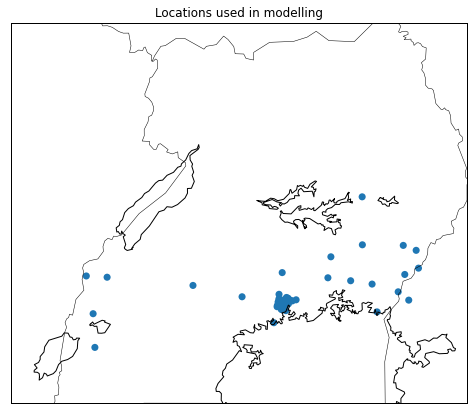

In [73]:
#Showing locations on map
from mpl_toolkits.basemap import Basemap
long = [X[:,0][index] for index in sorted(np.unique(X[:,0], return_index=True)[1])]
lat = [X[:,1][index] for index in sorted(np.unique(X[:,1], return_index=True)[1])]
plt.figure(figsize =(10,7))
base_map = Basemap(projection='merc',llcrnrlat=-1,urcrnrlat=4,
            llcrnrlon=29,urcrnrlon=35,lat_ts=20,resolution='i')
base_map.drawcoastlines()
base_map.drawcountries()
base_map.drawmapboundary(fill_color='white')
jet = plt.cm.get_cmap('jet')
x,y = base_map(long,lat)
sc = plt.scatter(x, y, cmap=jet, s=50, edgecolors='none')
plt.title('Locations used in modelling')
plt.savefig('locations_considered.png')

plt.show()

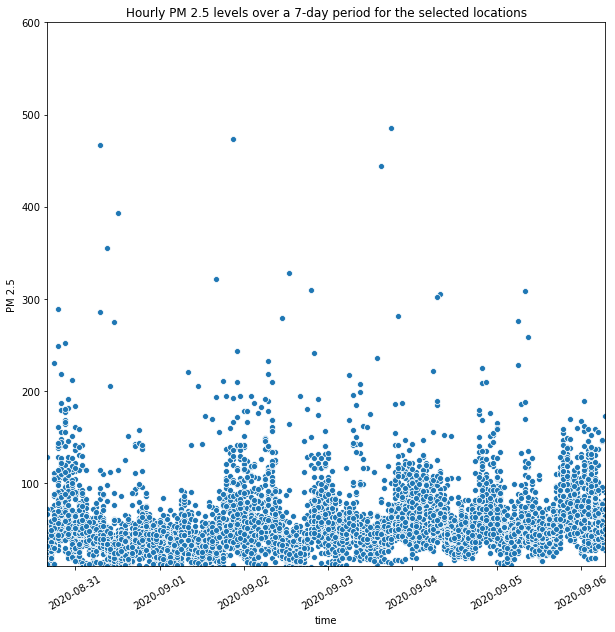

In [74]:
#Plotting PM levels over time
df1 = pd.DataFrame(X, columns = ['longitude', 'latitude', 'created_at'])
df2 = pd.DataFrame(Y, columns = ['PM 2.5'])
df = pd.concat([df1, df2], axis=1)

def generate_time(row):
    from pandas import Timestamp
    return Timestamp.fromtimestamp(row['created_at']*3600)
    
df['time'] = df.apply(lambda row: generate_time(row), axis=1)

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x="time", y="PM 2.5", data=df);
plt.xlim(df['time'].min(), df['time'].max())
plt.ylim(10, 600)
plt.title('Hourly PM 2.5 levels over a 7-day period for the selected locations')
plt.gca().xaxis.set_tick_params(rotation = 30)  
plt.savefig('pm_over_time_all.png')
plt.show()

#### Creating training set

In [75]:
#ounting the number of zeros in the array
np.count_nonzero(Y==0)

116

In [76]:
Y.shape

(7495, 1)

In [77]:
#Replacing zeros with NaNs
Yset = Y
Yset[Yset==0] = np.nan

In [78]:
keep = ~np.isnan(Yset[:,0]) #remove nans from data...
Yset = Yset[keep,:]
Xset = X[keep,:]

In [79]:
Xtraining = Xset[::10,:]
Ytraining = Yset[::10,:]

#### Creating and training the model

In [80]:
k = gpflow.kernels.RBF(lengthscales=[0.01, 0.01, 1.]) + gpflow.kernels.Bias()
print_summary(k)

╒═════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════╕
│ name                        │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value            │
╞═════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════╡
│ Sum.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0              │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ Sum.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ (3,)    │ float64 │ [0.01 0.01 1.  ] │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ Sum.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0              │
╘═════════════════════════════╧═

In [81]:
m = gpflow.models.GPR(data=(Xtraining, Ytraining), kernel=k, mean_function=None)
set_trainable(m.kernel.kernels[0].lengthscales, False) 
print_summary(m)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value            │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0              │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ False       │ (3,)    │ float64 │ [0.01 0.01 1.  ] │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │

#### Model Optimization

In [82]:
opt = gpflow.optimizers.Scipy()

def objective_closure():
    return - m.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value              │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2251.592239953446  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ False       │ (3,)    │ float64 │ [0.01 0.01 1.  ]   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Soft

#### Making predictions for 9 locations at 6 times of the day

In [83]:
longitudes = np.linspace(31, 33, 3)
latitudes = np.linspace(0.2, 1.2, 3)
locations = np.meshgrid(longitudes, latitudes)
locations

[array([[31., 32., 33.],
        [31., 32., 33.],
        [31., 32., 33.]]),
 array([[0.2, 0.2, 0.2],
        [0.7, 0.7, 0.7],
        [1.2, 1.2, 1.2]])]

In [84]:
#creating locations from coordinates
locations_flat = np.c_[locations[0].flatten(),locations[1].flatten()]
locations_flat

array([[31. ,  0.2],
       [32. ,  0.2],
       [33. ,  0.2],
       [31. ,  0.7],
       [32. ,  0.7],
       [33. ,  0.7],
       [31. ,  1.2],
       [32. ,  1.2],
       [33. ,  1.2]])

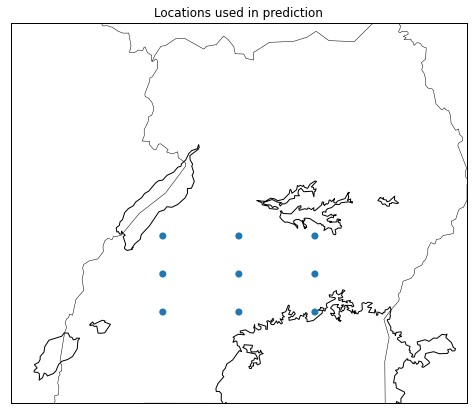

In [85]:
#Showing test locations on map
from mpl_toolkits.basemap import Basemap
long = locations_flat[:,0]
lat = locations_flat[:,1]
plt.figure(figsize =(10,7))
base_map = Basemap(projection='merc',llcrnrlat=-1,urcrnrlat=4,
            llcrnrlon=29,urcrnrlon=35,lat_ts=20,resolution='i')
base_map.drawcoastlines()
base_map.drawcountries()
base_map.drawmapboundary(fill_color='white')
jet = plt.cm.get_cmap('jet')
x,y = base_map(long,lat)
sc = plt.scatter(x, y, cmap=jet, s=50, edgecolors='none')
plt.title('Locations used in prediction')
plt.savefig('locations_prediction.png')

plt.show()

In [86]:
#creating 6 times of the day for which to make predictions
times = np.linspace(4.442e5, 4.442e5+5, 6)
times

array([444200., 444201., 444202., 444203., 444204., 444205.])

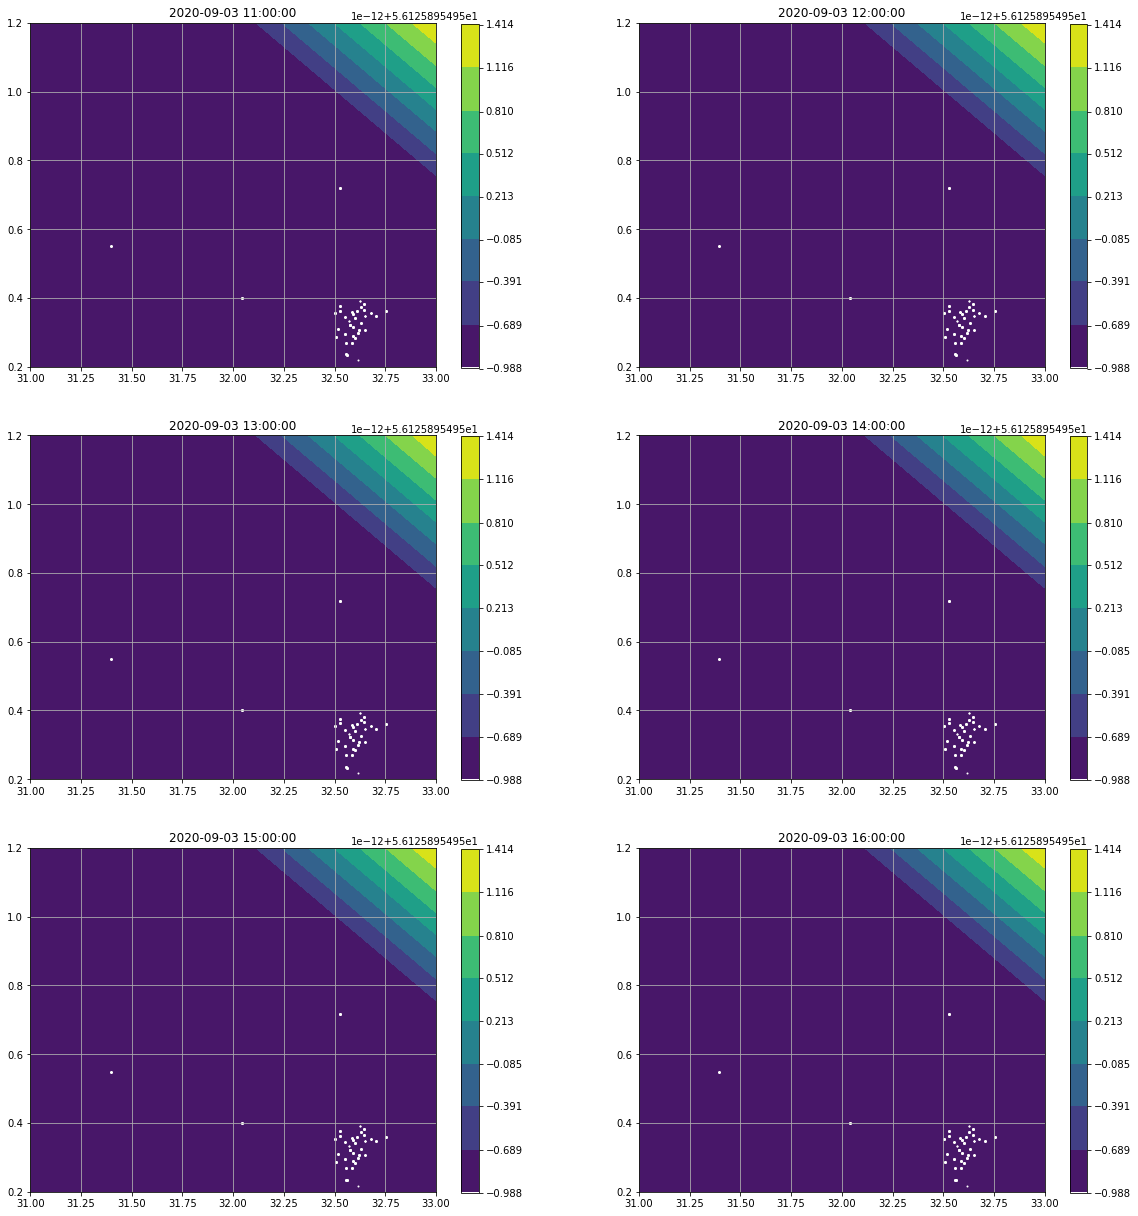

In [87]:
#Visualizing predictions
plt.figure(figsize=[20,105])
i=0
for time in times:
    XnewRow = np.c_[locations_flat,np.full(locations_flat.shape[0], time)]
    predicted_means,predicted_vars = m.predict_f(XnewRow)
    
    i+=1
    plt.subplot(14,2,i)
    plt.xlim([31,33])
    plt.ylim([0.2,1.2])
    plt.contourf(locations[0],locations[1],predicted_means.numpy().reshape([3,3]))
    plt.colorbar()
    plt.scatter(Xtraining[:,0],Xtraining[:,1],1,color='w')
    plt.title(Timestamp.fromtimestamp(time*3600))
    plt.grid()
    

#### Cross-validation

In [88]:
#Removing one location's data from X
long, lat = 32.5757, 0.322320

In [89]:
Xtrainingcv = X[np.logical_not(np.logical_and(X[:,0]==long, X[:,1]==lat))]
Xtrainingcv.shape

(7335, 3)

In [90]:
#data of deleted location
Xtest = X[np.logical_and(X[:,0]==long, X[:,1]==lat)]
Xtest.shape

(160, 3)

In [91]:
#getting the indices of the rows with that locations' data
location_indices = np.where(np.logical_and(X[:,0]==long, X[:,1]==lat))

In [92]:
Ytrainingcv = np.delete(Y, slice(location_indices[0][0],location_indices[0][-1]+1), axis=0)
Ytrainingcv.shape

(7335, 1)

In [93]:
Ytest = Y[location_indices[0][0]:location_indices[0][-1]+1]
Ytest.shape

(160, 1)

In [94]:
#Training the Model
m_cv = gpflow.models.GPR(data=(Xtrainingcv, Ytrainingcv), kernel=k, mean_function=None)
set_trainable(m_cv.kernel.kernels[0].lengthscales, False) 
print_summary(m_cv)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value              │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2251.592239953446  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ False       │ (3,)    │ float64 │ [0.01 0.01 1.  ]   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Soft

In [111]:
Y.shape

(7495, 1)

In [112]:
def objective_closure():
    return - m_cv.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m_cv.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m_cv)

InvalidArgumentError:  Input matrix is not invertible.
	 [[node MatrixTriangularSolve (defined at c:\users\user\anaconda3\envs\gaussian_env\lib\site-packages\gpflow\logdensities.py:96) ]] [Op:__inference__tf_eval_7361]

Errors may have originated from an input operation.
Input Source operations connected to node MatrixTriangularSolve:
 sub (defined at c:\users\user\anaconda3\envs\gaussian_env\lib\site-packages\gpflow\logdensities.py:95)	
 Cholesky (defined at c:\users\user\anaconda3\envs\gaussian_env\lib\site-packages\gpflow\models\gpr.py:71)

Function call stack:
_tf_eval


In [ ]:
Xtest

In [ ]:
#Making predictions for the test location
m_cv.predict_y(Xtest)